In [21]:
import numpy as np
import scipy.stats as sps
from glob import glob
import matplotlib.pyplot as plt
import uproot as ur
import ROOT as rt
import ROOT.RooFit as rf
from array import array
from scipy.special import erf
import sys, os
sys.path.append('../lib')
from histo_utilities import create_TH1D, create_TH2D, std_color_list, SetMaxToMaxHist, make_ratio_plot
from cebefo_style import Set_2D_colz_graphics
from progressBar import ProgressBar

from analysis_utilities import drawOnCMSCanvas, extarct, extarct_multiple, createSel
from lumi_utilities import getLumiReport

import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 1
CMS_lumi.extraText = "     Simulation Preliminary"

donotdelete = []

In [2]:
rt.gErrorIgnoreLevel = rt.kError
rt.RooMsgService.instance().setGlobalKillBelow(rt.RooFit.ERROR)

In [3]:
m_pi = 0.13957
m_K = 0.49368
m_D0 = 1.86483 #1e-3*Particle.from_string('D0').mass
m_Dst = 2.01026 #1e-3*Particle.from_string('D*+').mass
m_B0 = 5.27963 #1e-3*Particle.from_string('B0').mass
m_pi = 0.13957018 #1e-3*Particle.from_string('pi+').mass
print 'mD* - mD0 =', m_Dst - m_D0

mD* - mD0 = 0.14543


In [4]:
label_dic = {'Data' : 'Data',
             'mu'   : 'B#rightarrow D*#mu#nu',
             'tau'  : 'B#rightarrow D*#tau#nu',
             'Hc'   : 'B#rightarrow D*H_{c}',
             'Dstst': 'B#rightarrow D**#mu#nu'
            }

In [5]:
colors = {'data':rt.kBlack,
          'mu': rt.kAzure+1, 
          'tau': rt.kRed-4, 
          'Hc':rt.kGreen+1, 
          'Dstst': rt.kViolet-7,
          'combDstMum' : rt.kGray+1
         }

In [6]:
cl = rt.TLine()
cl.SetLineColor(6)
cl.SetLineStyle(9)
cl.SetLineWidth(2)

In [7]:
import operator
ops = {'>': operator.gt, '<': operator.lt, }

# Load data

In [8]:
loc = '../data/cmsRD/'
loc += 'ParkingBPH1/'
loc += 'Run2018D-05May2019promptD-v1_RDntuplizer_B2DstMu_191126_CAND.root'

tData = rt.TChain('outA/Tevts')
for floc in glob(loc):
    tData.Add(floc)

print 'N evts: {:.0f}'.format(tData.GetEntries())

N evts: 533512


In [9]:
loc = '../data/cmsMC_private/'
loc += 'BPH_Tag-B0_MuNuDmst-pD0bar-kp_13TeV-pythia8_Hardbbbar_PTFilter5_0p0-evtgen_ISGW2_PU20_10-2-3'
loc += '/ntuples_B2DstMu/out_CAND_*.root'

tMu = rt.TChain('outA/Tevts')
for floc in glob(loc):
    tMu.Add(floc)

print 'N evts: {:.0f}'.format(tMu.GetEntries())

N evts: 792733


In [10]:
loc = '../data/cmsMC_private/'
loc += 'BPH_Tag-B0_TauNuDmst-pD0bar-kp-t2mnn_pythia8_Hardbbbar_PTFilter5_0p0-evtgen_ISGW2_PU20_10-2-3'
loc += '/ntuples_B2DstMu/out_CAND_*.root'

tTau = rt.TChain('outA/Tevts')
for floc in glob(loc):
    tTau.Add(floc)

print 'N evts: {:.0f}'.format(tTau.GetEntries())

N evts: 81453


In [11]:
loc = '../data/cmsMC_private/'
loc += 'BPH_Tag-Bp_MuNuDstst_DmstPi_13TeV-pythia8_Hardbbbar_PTFilter5_0p0-evtgen_ISGW2_PU20_10-2-3'
loc += '/ntuples_B2DstMu/out_CAND_*.root'

tDstst = rt.TChain('outA/Tevts')
for floc in glob(loc):
    tDstst.Add(floc)

print 'N evts: {:.0f}'.format(tDstst.GetEntries())

N evts: 85378


# Cuts declaration

In [12]:
cut_general = [
    'n_B == 1',
    'trgMu_pt > 12.1',
    'trgMu_sigdxy > 7'
]

# $D_0$ reconstruction

In [13]:
cut_piK = [
####----- Trigger-like cuts -----#
'K_pt > 0.8',
'pi_pt > 0.8',
'pval_piK > 0.1',
'abs(K_eta) < 2.4',
'abs(pi_eta) < 2.4',
    
# 'cosT_Jpsi_PV > 0.95',
# 'sigdxy_K_PV > 2',
# 'mup_dxy < 2',
]

In [14]:
cut_piK += ['mass_D0pis < mass_piK + 0.16', 'abs(mass_piK - 1.86) < 0.04']
cut_piK = list(dict.fromkeys(cut_piK))
cut_piK

['abs(K_eta) < 2.4',
 'K_pt > 0.8',
 'abs(mass_piK - 1.86) < 0.04',
 'mass_D0pis < mass_piK + 0.16',
 'pval_piK > 0.1',
 'abs(pi_eta) < 2.4',
 'pi_pt > 0.8']

# $D^*$ Recostruction

In [15]:
cut_D0pis = [
'pis_pt > 0.5',
'abs(pis_eta) < 2.4',
'pis_refitD0pismu_pt > 0.5',
'sigdxy_pis_PV > 2',
'pval_D0pis > 0.1',
'cos_D0pismu_PV > 0.99'
]

In [16]:
cut_str = ' && '.join(cut_general + cut_piK + cut_D0pis)
print cut_str

n_B == 1 && trgMu_pt > 12.1 && trgMu_sigdxy > 7 && abs(K_eta) < 2.4 && K_pt > 0.8 && abs(mass_piK - 1.86) < 0.04 && mass_D0pis < mass_piK + 0.16 && pval_piK > 0.1 && abs(pi_eta) < 2.4 && pi_pt > 0.8 && pis_pt > 0.5 && abs(pis_eta) < 2.4 && pis_refitD0pismu_pt > 0.5 && sigdxy_pis_PV > 2 && pval_D0pis > 0.1 && cos_D0pismu_PV > 0.99


In [17]:
cut_D0pis += ['abs(mass_D0pis - 2.01) < 0.03']
cut_D0pis = list(dict.fromkeys(cut_D0pis))
print cut_D0pis

['abs(pis_eta) < 2.4', 'pis_pt > 0.5', 'pis_refitD0pismu_pt > 0.5', 'cos_D0pismu_PV > 0.99', 'sigdxy_pis_PV > 2', 'pval_D0pis > 0.1', 'abs(mass_D0pis - 2.01) < 0.03']


# Full analysis

In [18]:
cut_B = [
    'pval_D0pismu > 0.1',
    'mass_D0pismu < 7.0'
]
print cut_B

cut_str = ' && '.join(cut_general + cut_piK + cut_D0pis + cut_B)

['pval_D0pismu > 0.1', 'mass_D0pismu < 7.0']


# Study on the additional tracks

Mu: 22910/145211 = 15.8 %
Tau: 1419/11140 = 12.7 %
Dstst: 11625/14265 = 81.5 %


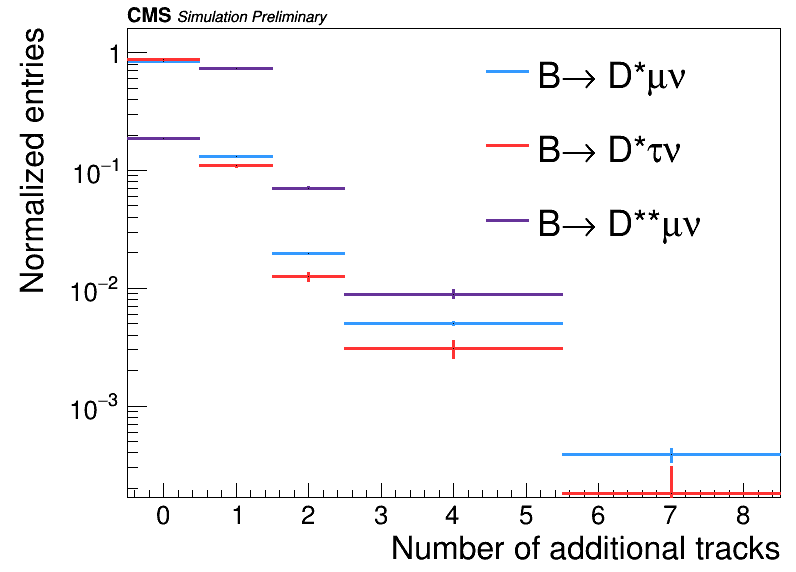

In [25]:
h = create_TH1D(np.zeros(0), name='h',
                title='',
                axis_title=['Number of additional tracks', 'Normalized entries'],
                binning=array('d', list(np.arange(-0.5, 3.5, 1)) + [5.5, 8.5] )
               )
tMu.Project('h', 'nTksAdd', cut_str)
h.Sumw2()
h.Scale(1./h.Integral())
h.SetLineColor(colors['mu'])
h.SetLineWidth(3)
N = tMu.GetEntries(cut_str)
n = tMu.GetEntries(cut_str + ' && nTksAdd >= 1')
print 'Mu: {}/{} = {:.1f} %'.format(n, N, 100*float(n)/N)

h3 = create_TH1D(np.zeros(0), name='h3', binning=h.binning)
tTau.Project('h3', 'nTksAdd', cut_str)
h3.Sumw2()
h3.Scale(1./h3.Integral())
h3.SetLineColor(colors['tau'])
h3.SetLineWidth(3)
N = tTau.GetEntries(cut_str)
n = tTau.GetEntries(cut_str + ' && nTksAdd >= 1')
print 'Tau: {}/{} = {:.1f} %'.format(n, N, 100*float(n)/N)

h2 = create_TH1D(np.zeros(0), name='h2', binning=h.binning)
tDstst.Project('h2', 'nTksAdd', cut_str)
h2.Sumw2()
h2.Scale(1./h2.Integral())
h2.SetLineColor(colors['Dstst'])
h2.SetLineWidth(3)
N = tDstst.GetEntries(cut_str)
n = tDstst.GetEntries(cut_str + ' && nTksAdd >= 1')
print 'Dstst: {}/{} = {:.1f} %'.format(n, N, 100*float(n)/N)

leg = rt.TLegend(0.6, 0.55, 0.9, 0.94)
leg.AddEntry(h, label_dic['mu'], 'l')
leg.AddEntry(h3, label_dic['tau'], 'l')
leg.AddEntry(h2, label_dic['Dstst'], 'l')
leg.SetTextFont(42)
leg.SetTextAlign(12)
leg.SetLineWidth(0)
leg.SetBorderSize(0)
c = drawOnCMSCanvas(CMS_lumi, [h, h2, h3], 'same')
c.SetLogy()
leg.Draw()
c.Draw()

Dstst: 8546/14265 = 59.9 %
Tau: 110/11140 = 1.0 %


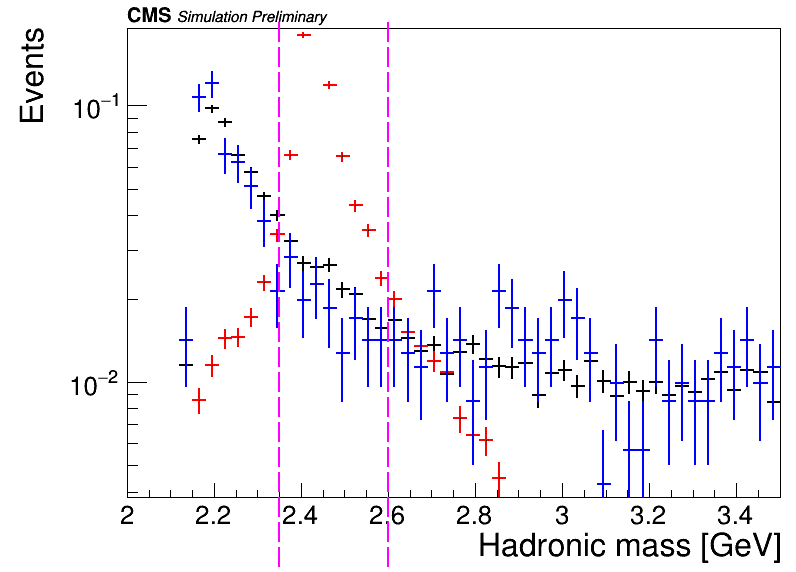

In [26]:
h = create_TH1D(np.zeros(0), name='h',
                title='',
                axis_title=['Hadronic mass [GeV]', 'Events'],
                binning=[50, 2, 3.5]
               )
tMu.Project('h', 'tksAdd_massHad', cut_str)
h.Sumw2()
h.Scale(1./h.Integral())

h2 = create_TH1D(np.zeros(0), name='h2', binning=h.binning)
tDstst.Project('h2', 'tksAdd_massHad', cut_str)
h2.Sumw2()
h2.Scale(1./h2.Integral())
h2.SetLineColor(rt.kRed)
N = tDstst.GetEntries(cut_str)
n = tDstst.GetEntries(cut_str + ' && tksAdd_massHad > 2.35 && tksAdd_massHad < 2.6')
print 'Dstst: {}/{} = {:.1f} %'.format(n, N, 100*float(n)/N)  

h3 = create_TH1D(np.zeros(0), name='h3', binning=h.binning)
tTau.Project('h3', 'tksAdd_massHad', cut_str)
h3.Sumw2()
h3.Scale(1./h3.Integral())
h3.SetLineColor(rt.kBlue)
N = tTau.GetEntries(cut_str)
n = tTau.GetEntries(cut_str + ' && tksAdd_massHad > 2.35 && tksAdd_massHad < 2.6')
print 'Tau: {}/{} = {:.1f} %'.format(n, N, 100*float(n)/N)  

c = drawOnCMSCanvas(CMS_lumi, [h, h2, h3], 'same')
c.SetLogy()
cl.DrawLine(2.35, 1e-3, 2.35, 0.2)
cl.DrawLine(2.6, 1e-3, 2.6, 0.2)
c.Draw()

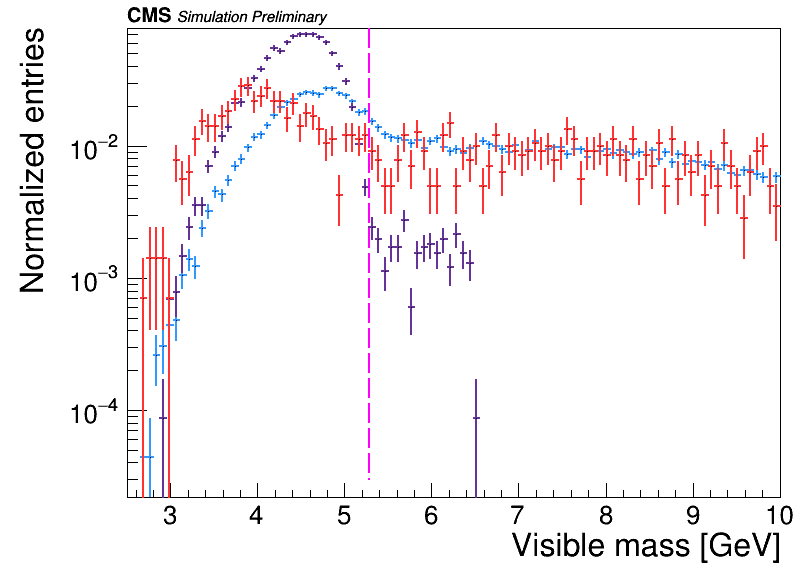

In [32]:
h = create_TH1D(np.zeros(0), name='h',
                title='',
                axis_title=['Visible mass [GeV]', 'Normalized entries'],
                binning=[100, 2.5, 10]
               )
tMu.Project('h', 'tksAdd_massVis', cut_str)
h.Sumw2()
h.Scale(1./h.Integral())
h.SetLineColor(colors['mu'])

h2 = create_TH1D(np.zeros(0), name='h2', binning=h.binning)
tDstst.Project('h2', 'tksAdd_massVis', cut_str)
h2.Sumw2()
h2.Scale(1./h2.Integral())
h2.SetLineColor(colors['Dstst'])

h3 = create_TH1D(np.zeros(0), name='h3', binning=h.binning)
tTau.Project('h3', 'tksAdd_massVis', cut_str)
h3.Sumw2()
h3.Scale(1./h3.Integral())
h3.SetLineColor(colors['tau'])
   
m = SetMaxToMaxHist([h, h2, h3])
c = drawOnCMSCanvas(CMS_lumi, [h, h2, h3], 'same')
c.SetLogy()
cl.DrawLine(m_B0, 3e-5, m_B0, m)
c.Draw()

In [ ]:
h = create_TH2D(np.zeros((2,2)), name='h',
                title='',
                axis_title=['Hadronic mass [GeV]', 'Visible mass [GeV]', 'Events'],
                binning=[np.linspace(2, 3.5, 30), np.linspace(2.5, 6.5, 30)]
               )
tMu.Project('h', 'tksAdd_massVis:tksAdd_massHad', cut_str)
h.Sumw2()

h2 = create_TH2D(np.zeros((2,2)), name='h2', binning=h.binning)
tDstst.Project('h2', 'tksAdd_massVis:tksAdd_massHad', cut_str)
h2.Sumw2()
h2.SetMarkerColor(rt.kRed)

h3 = create_TH2D(np.zeros((2,2)), name='h3', binning=h.binning)
tTau.Project('h3', 'tksAdd_massVis:tksAdd_massHad', cut_str)
h3.Sumw2()
h3.SetMarkerColor(rt.kBlue)
                         
c = drawOnCMSCanvas(CMS_lumi, [h, h2, h3], 'same')
# cl.DrawLine(1.76, 1.76+0.16, 1.91, 1.91+0.16)
# c.SetLogy()
c.Draw()

Mu: 11039/145211 = 7.6 %
Tau: 759/11140 = 6.8 %
Dstst: 11564/14265 = 81.1 %
Data: 20518/121107 = 16.9 %


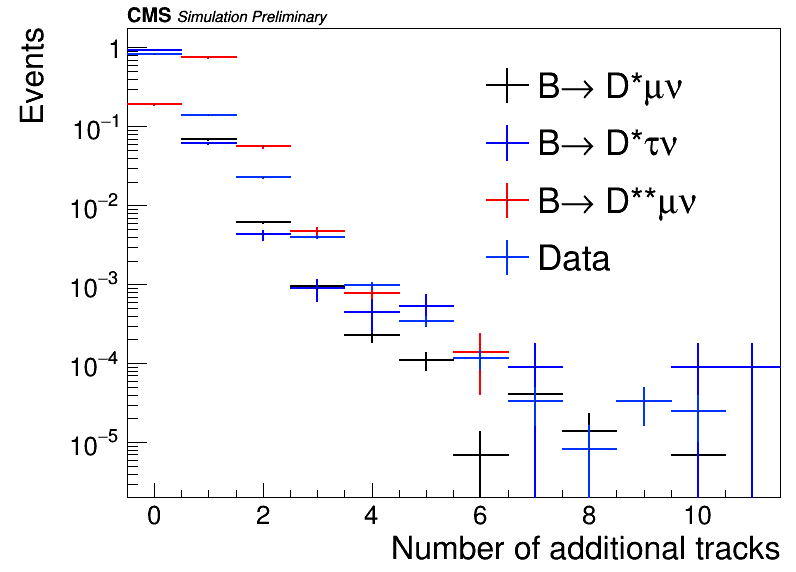

In [28]:
var = 'Sum$(tksAdd_massVis < {})'.format(m_B0)
# var = 'Sum$(tksAdd_massVis < {})'.format(6.5)
# var = 'Sum$(tksAdd_massVis < {} && tksAdd_massHad > 2.35 && tksAdd_massHad < 2.6)'.format(m_B0)

h = create_TH1D(np.zeros(0), name='h',
                title='',
                axis_title=['Number of additional tracks', 'Events'],
                binning=[12, -0.5, 11.5]
               )
tMu.Project('h', var, cut_str)
h.Sumw2()
h.Scale(1./h.Integral())
N = tMu.GetEntries(cut_str)
n = tMu.GetEntries(cut_str + ' && {} >= 1'.format(var))
print 'Mu: {}/{} = {:.1f} %'.format(n, N, 100*float(n)/N)

h3 = create_TH1D(np.zeros(0), name='h3', binning=h.binning)
tTau.Project('h3', var, cut_str)
h3.Sumw2()
h3.Scale(1./h3.Integral())
h3.SetLineColor(rt.kBlue)
N = tTau.GetEntries(cut_str)
n = tTau.GetEntries(cut_str + ' && {} >= 1'.format(var))
print 'Tau: {}/{} = {:.1f} %'.format(n, N, 100*float(n)/N)

h2 = create_TH1D(np.zeros(0), name='h2', binning=h.binning)
tDstst.Project('h2', var, cut_str)
h2.Sumw2()
h2.Scale(1./h2.Integral())
h2.SetLineColor(rt.kRed)
N = tDstst.GetEntries(cut_str)
n = tDstst.GetEntries(cut_str + ' && {} >= 1'.format(var))
print 'Dstst: {}/{} = {:.1f} %'.format(n, N, 100*float(n)/N)


h4 = create_TH1D(np.zeros(0), name='h4', binning=h.binning)
tData.Project('h4', var, cut_str)
h4.Sumw2()
h4.Scale(1./h4.Integral())
h4.SetLineColor(rt.kAzure)
N = tData.GetEntries(cut_str)
n = tData.GetEntries(cut_str + ' && {} >= 1'.format(var))
print 'Data: {}/{} = {:.1f} %'.format(n, N, 100*float(n)/N)

leg = rt.TLegend(0.6, 0.5, 0.9, 0.9)
leg.AddEntry(h, label_dic['mu'], 'lep')
leg.AddEntry(h3, label_dic['tau'], 'lep')
leg.AddEntry(h2, label_dic['Dstst'], 'lep')
leg.AddEntry(h4, label_dic['Data'], 'lep')
leg.SetTextFont(42)
leg.SetTextAlign(12)
leg.SetLineWidth(0)
leg.SetBorderSize(0)
c = drawOnCMSCanvas(CMS_lumi, [h, h2, h3, h4], 'same')
c.SetLogy()
leg.Draw()
c.Draw()